# k-Nearest Neighbors Prediction Model of Breast Cancer Diagnosis from The University of Wisconsin
Author: Jayanth Rao  

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction-" data-toc-modified-id="Introduction--1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction <a name="introduction"></a></a></span></li><li><span><a href="#Preprocessing-and-Feature-Creation-" data-toc-modified-id="Preprocessing-and-Feature-Creation--2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocessing and Feature Creation <a name="preprocessing"></a></a></span></li><li><span><a href="#Creation-of-The-Model-" data-toc-modified-id="Creation-of-The-Model--3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Creation of The Model <a name="model"></a></a></span></li><li><span><a href="#Cross-Validation-" data-toc-modified-id="Cross-Validation--4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Cross Validation <a name="validation"></a></a></span></li></ul></div>

## Introduction <a name="introduction"></a>

This dataset is from the University of Wisconsin, created by Dr. William H. Wolberg. He assessed the biopsies of breast cancer tumors for 699 patients. 9 attributes were recorded on a scale from 1 to 10, and the result of each diagnosis is known. The diagnonsis results were placed in the 'Class' column.

Dataset link: [Breast Cancer Wisconsin (Original)](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Original%29)  
Creator: Dr. William H. Wolberg (physician)  
University of Wisconsin Hospitals  
Madison, Wisconsin, USA  
July 15th, 1992  

## Preprocessing and Feature Creation <a name="preprocessing"></a>
I had to polish the data in order to set the model up. To do so, I normalized the 'Class' scale by setting a diagnosis marked 'Benign' to 0, and a diagnosis marked 'Malignant' to 1. Also, 16 values were missing from the Bare Nuclei column, and to address this, I deleted the rows these missing values were in. Ultimately, my model was built on 683 total values. 

I also created a Correlation Matrix to give myself an idea on which features would be strongly correlated with each other.

In [1]:
# Uncomment this install if the seaborn package is not installed in your environment
# pip install seaborn

In [2]:
import numpy as np
import random
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict

In [3]:
bc_data = pd.read_csv('breast-cancer-wisconsin_new.txt', header=None)
bc_data.columns = ['ID', 'ClumpThickness', 'UniformityOfCellSize', 'UniformityOfCellShape', 'MarginalAdhesion','EpithelialCellSize', 'BareNuclei', 'BlandChromatin', 'NormalNucleoli', 'Mitoses', 'Class']


def binary_vals(x):
    if x == 2:
        return 0
    return 1

# preprocessing of the class (0 -> benign, 1 -> malignant)
bc_data['Class'] = bc_data.apply(lambda row: binary_vals(row['Class']), axis=1)

for i in bc_data.columns:
    bc_data[i] = pd.to_numeric(bc_data[i], errors='coerce')
    
bc_data = bc_data.dropna()
bc_data.head(10)

,ID,ClumpThickness,UniformityOfCellSize,UniformityOfCellShape,MarginalAdhesion,EpithelialCellSize,BareNuclei,BlandChromatin,NormalNucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1.0,3,1,1,0
1,1002945,5,4,4,5,7,10.0,3,2,1,0
2,1015425,3,1,1,1,2,2.0,3,1,1,0
3,1016277,6,8,8,1,3,4.0,3,7,1,0
4,1017023,4,1,1,3,2,1.0,3,1,1,0
5,1017122,8,10,10,8,7,10.0,9,7,1,1
6,1018099,1,1,1,1,2,10.0,3,1,1,0
7,1018561,2,1,2,1,2,1.0,3,1,1,0
8,1033078,2,1,1,1,2,1.0,1,1,5,0
9,1033078,4,2,1,1,2,1.0,2,1,1,0


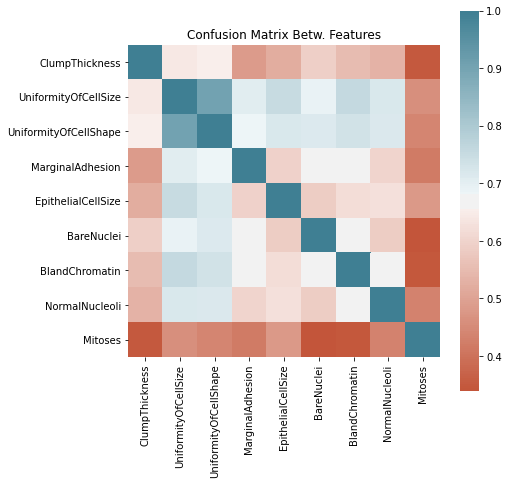

In [4]:
# Generate a Confusion Matrix of the features to see which are strongly correlated with each other
columns_df = bc_data[['ClumpThickness', 'UniformityOfCellSize', 'UniformityOfCellShape', 'MarginalAdhesion','EpithelialCellSize', 'BareNuclei', 'BlandChromatin', 'NormalNucleoli', 'Mitoses']]
values = columns_df.values

features = ['ClumpThickness', 'UniformityOfCellSize', 'UniformityOfCellShape', 'MarginalAdhesion','EpithelialCellSize', 'BareNuclei', 'BlandChromatin', 'NormalNucleoli', 'Mitoses']

fig = plt.figure(figsize=(7,7))
corrMatrix = columns_df.corr()
sn.heatmap(corrMatrix, 
           cmap=sn.diverging_palette(20, 220, n=200),
           square=True)
plt.title("Confusion Matrix Betw. Features")
plt.show()

As seen from the Confusion Matrix, Uniformity of Cell Size and Uniformity of Cell Shape are quite strongly correlated, but the other features are fairly independent of each other.

In [5]:
# Feature creation
features = bc_data[['ClumpThickness', 'UniformityOfCellSize', 'UniformityOfCellShape', 'MarginalAdhesion', 'EpithelialCellSize', 'BareNuclei', 'BlandChromatin', 'NormalNucleoli', 'Mitoses']]

# set them all as floating point values
features = preprocessing.StandardScaler().fit(features).transform(features.astype(float))

## Creation of The Model <a name="model"></a>
I selected a <b>K-Nearest Neighbors Classification Model</b>, as the predictions were going to be binary (benign or malignant).

To do so, I first needed to split the dataset into a training set and a testing set. The model would be created based on the training set, and then would be put to use on the testing set to provide an accuracy value. I split the data on a 90-10 ratio, as that is usually the standard for K-Nearest Neighbors Classification.

To find the optimal Nearest Neighbor value, I iterated over 20 nearest neighbors and from there, found the count that gave me the highest accuracy in my train set. I created my model based off this value.

In [6]:
# Response Variable
prediction_col = bc_data['Class'].values

In [7]:
# Setup the train and test sets
feature_train, feature_test, pred_train, pred_test = train_test_split(features, prediction_col, test_size=0.1, random_state=45)

In [8]:
# Train and Test sets:
print('Train set:', feature_train.shape, pred_train.shape)
print('Test set:', feature_test.shape, pred_test.shape)

Train set: (614, 9) (614,)
Test set: (69, 9) (69,)


In [9]:
# K count:
kCount = range(1,20,1)
training_accuracy = []
test_accuracy = []

In [10]:
# Build lists of various nearest neighbor values to find the best one
for i in kCount:
    # train the model and perform a prediction
    knn_model = KNeighborsClassifier(n_neighbors=i).fit(feature_train, pred_train)
    prediction = knn_model.predict(feature_test)
    
    # Evaluation of Accuracy
    training_accuracy.append(metrics.accuracy_score(pred_train, knn_model.predict(feature_train)))
    test_accuracy.append(metrics.accuracy_score(pred_test, prediction))

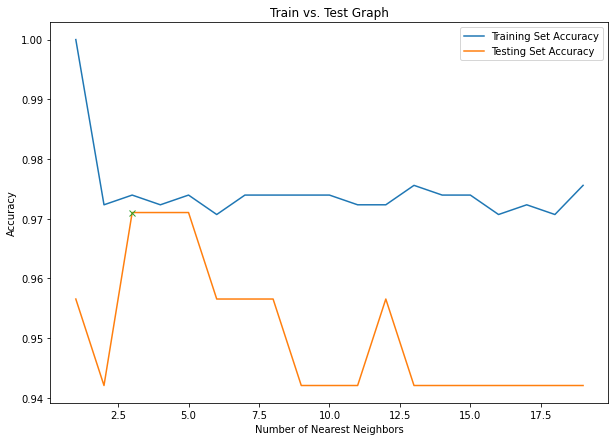

In [11]:
# Plot the Accuracy of the Training Set vs. Accuracy of the Testing Set
fig = plt.figure(figsize=(10,7))
plt.plot(kCount, training_accuracy, label="Training Set Accuracy")
plt.plot(kCount, test_accuracy, label='Testing Set Accuracy')
max_index = test_accuracy.index(max(test_accuracy))
plt.plot(max_index + 1, test_accuracy[max_index], 'x')  # indicate the nearest neighbor with the best accuracy
plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Accuracy')
plt.title('Train vs. Test Graph')
plt.legend()
plt.show()

As seen from the graph of the Nearest Neighbors vs. the Accuracy, the number of Nearest Neighbors that provided the highest accuracy was 5. 

In [12]:
knn_model = KNeighborsClassifier(n_neighbors = 5).fit(feature_train, pred_train)
prediction = knn_model.predict(feature_test)

print("Train Set Accuracy:", metrics.accuracy_score(pred_train, knn_model.predict(feature_train)))
print("Test Set Accuracy:", metrics.accuracy_score(pred_test, prediction))

Train Set Accuracy: 0.9739413680781759
Test Set Accuracy: 0.9710144927536232


The accuracy of the prediction for the testing set was quite good. However, I believe it could have been better if the rows that were initially dropped were included, as that would have added to the sample size without creating too much extra noise.


## Cross Validation <a name="validation"></a>
To check make sure my model was not overfitting nor underfitting the dataset, I implemented a Cross Validation Score. The cross validation method I used was the K-Folds Cross Validation.

In [13]:
# K-Fold Implementation
kfold = KFold(10, True)
print("Splits for K-Fold Validation:", kfold.get_n_splits(features))

Splits for K-Fold Validation: 10


In [14]:
for train_index, test_index in kfold.split(features):
    feature_train, feature_test = features[train_index], features[test_index]
    pred_train, pred_test = prediction_col[train_index], prediction_col[test_index]

In [15]:
kNN = KNeighborsClassifier(n_neighbors=5)
score = cross_val_score(kNN, features, prediction_col, cv=45)
print('Cross Validation Mean Score:', score.mean())

Cross Validation Mean Score: 0.9679629629629629


To create the k-Fold Cross Validation score, I used 10 folds (a good number to use for this validation method). The reason I chose this number was to divide the 684 values into equal groups of data. The Cross Validation Score that was found shows that the model did a pretty decent job of not underfitting nor overfitting the dataset.